In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/COMP9417_MoA_Prediction/notebooks

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import *
from scipy.special import expit
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


In [7]:
def seed_everything(seed, use_cuda=False):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if use_cuda:
        torch.cuda.manual_seed(seed)

    torch.backends.cudnn.deterministic = True 

In [1]:
EPOCHS = 30
BATCH_SIZE = 1024
LEARNING_RATE = 2e-2
WEIGHT_DECAY = 1e-5
SEED = 42
NUM_FOLDS = 5

# **READING IN AND EXAMINING THE DATA**

In [6]:
def preprocess(df):
    
    df['cp_dose'] = df['cp_dose'].map({'D1': 0, 'D2': 1})
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72:2})
    df = df.drop('cp_type', axis=1)
    df = df.drop('sig_id', axis=1)
        
    return df


def prepare_data(dir):
    X_train = pd.read_csv(f'{dir}/train_features.csv')
    Y_train = pd.read_csv(f'{dir}/train_targets_scored.csv')
    X_test = pd.read_csv(f'{dir}/test_features.csv')
    ss = pd.read_csv(f'{dir}/sample_submission.csv')

    train = X_train.merge(Y_train, on='sig_id')
    X_train = train.loc[:, X_train.columns]
    Y_train = train.loc[:, Y_train.columns]

    # Remove control samples
    is_ctl_train = X_train['cp_type'] != 'ctl_vehicle'
    X_train = X_train[is_ctl_train].reset_index(drop=True)
    Y_train = Y_train[is_ctl_train].reset_index(drop=True)
    
    is_ctl_test = X_test['cp_type'] != 'ctl_vehicle'
    X_test = X_test[is_ctl_train].reset_index(drop=True)


    X_train = preprocess(X_train)
    X_test = preprocess(X_test)
    
    Y_train = Y_train.drop('sig_id', axis=1)
    return X_train, Y_train, X_test, ss

In [7]:
X_train, Y_train, X_test, ss = prepare_data('../data/lish-moa')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Text(0.5, 1.0, 'Correlation Heatmap between MoAs')

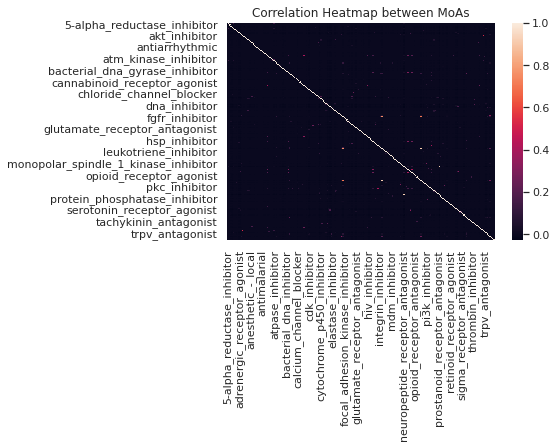

In [51]:
sns.set_theme()
targetCorrMatrix = Y_train.corr()
targetHeatmap = sns.heatmap(targetCorrMatrix)
targetHeatmap.set_title('Correlation Heatmap between MoAs')


Text(0.5, 1.0, 'Correlation Heatmap between genes')

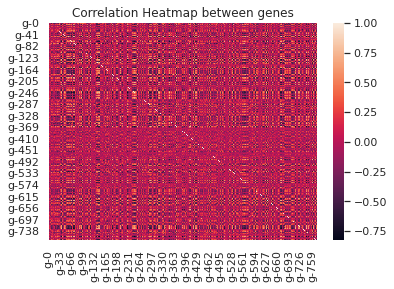

In [47]:
geneCorrMatrix = X_train.iloc[:,2:774].corr()
cellCorrMatrix = X_train.iloc[:,774:].corr()

geneHeatmap = sns.heatmap(geneCorrMatrix)
geneHeatmap.set_title('Correlation Heatmap between genes')


Text(0.5, 1.0, 'Correlation Heatmap between cells')

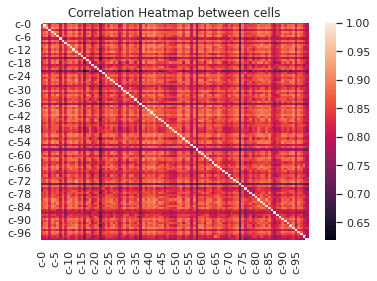

In [50]:
cellHeatmap = sns.heatmap(cellCorrMatrix)
cellHeatmap.set_title('Correlation Heatmap between cells')


# **Model 1: Simple NN**

In [5]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,
                 output_size, dropout=0.2):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [6]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features.values
        self.targets = targets.values
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        idx_features = torch.tensor(self.features[idx], dtype=torch.float)
        idx_targets = torch.tensor(self.targets[idx], dtype=torch.float)
        return idx_features, idx_targets


class TestMoADataset:
    def __init__(self, features):
        self.features = features.values
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        idx_features = torch.tensor(self.features[idx], dtype=torch.float)
        return idx_features

### **Training and Testing**

In [ ]:
def train_fun(model, optimizer, loss_fun, train_loader, device, epoch):
    model.train()
    running_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fun(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(train_loader):
        #     print(f'Train Epoch: {epoch + 1}, Batch: [{(batch_idx + 1)}/{len(train_loader)}], Loss: {loss.item():.3f}')

    mean_loss = running_loss / len(train_loader)
    return mean_loss


def validate_fun(model, loss_fun, val_loader, device, epoch):
    model.eval()
    running_loss = 0

    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
        
        loss = loss_fun(outputs, targets)
        running_loss += loss.item()

        # if (batch_idx + 1) % 1024 == 0 or (batch_idx + 1) == len(val_loader):
        #     print(f'Validate Epoch: {epoch + 1}, Batch: [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.6f}')

    mean_loss = running_loss / len(val_loader)
    return mean_loss


def test_fun(model, test_loader, device):
    Y_pred_lst = []
    model.eval()

    for batch_idx, inputs in enumerate(test_loader):
        inputs = inputs.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)

        Y_pred_lst.append(outputs.sigmoid().detach().cpu().numpy())

    Y_pred = np.concatenate(Y_pred_lst)

    return Y_pred


In [ ]:
def train_simple_net(fold, X_test, train_loader, val_loader, in_size, out_size, device):
    model = SimpleNet(in_size, 2048, 1024, out_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fun = nn.BCEWithLogitsLoss()
    best_loss = np.inf

    for epoch in range(EPOCHS):
        epoch_train_loss = train_fun(model, optimizer, loss_fun, train_loader, device, epoch)
        epoch_val_loss = validate_fun(model, loss_fun, val_loader, device, epoch)

        # print(f'Epoch: {epoch}, Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}')

        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            torch.save(model.state_dict(), f'simple_fold_{fold + 1}.pth')
    
    test_dataset = TestMoADataset(X_test)   
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = SimpleNet(in_size, 2048, 1024, out_size).to(device)
    model.load_state_dict(torch.load(f'simple_fold_{fold + 1}.pth'))
    model.to(device)

    Y_pred = test_fun(model, test_loader, device)

    return best_loss, Y_pred

In [28]:
def my_log_loss(y_test,y_pred):
    y_test = y_test.cpu().detach().numpy().astype(np.float16)
    y_pred = y_pred.cpu().detach().numpy().astype(np.float16).reshape(-1,2)
    N,M = y_test.shape
    print("test N: ",N, "test M: ", M)
    print("pred N: ",y_pred.shape[0], "pred M: ", y_pred.shape[1])

    a=[]
    for m in range(M-1):
        loss=0
        for i in range(N-1):
            loss -= ((y_test[i,m]*np.log(y_pred[i,m]))+((1.0-y_test[i,m])*np.log(1.0-y_pred[i,m])))
        loss = loss/N
        a.append(round(loss,8))
    return a

# **Model 2: TabNet**

In [ ]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric


In [8]:
class LogitsLogLoss(Metric):

    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        # BCE loss for each target label (MoA)
        # The predictions must run through sigmoid as they need to be probabilities
        BCE = (1 - y_true) * np.log(1 - expit(y_pred) + 1e-15) +
               y_true * np.log(expit(y_pred) + 1e-15)
        return np.mean(-BCE)

In [30]:
def train_tabnet(fold, X_test, trainX, trainY, valX, valY, in_size, out_size):

    tabnet_params = dict(
                        n_d = 32,
                        n_a = 32,
                        n_steps = 1,
                        gamma = 1.3,
                        lambda_sparse = 0,
                        optimizer_fn = torch.optim.Adam,
                        optimizer_params = dict(lr = LEARNING_RATE, weight_decay = 1e-5),
                        mask_type = "entmax",
                        verbose = 10
                      )
    model = TabNetRegressor(**tabnet_params)
    model.fit(
        X_train = trainX.to_numpy(), 
        y_train=trainY.to_numpy(),
        eval_set = [(valX.to_numpy(), valY.to_numpy())],
        eval_name = ["val"],
        eval_metric = ["logits_ll"],
        max_epochs = EPOCHS,
        patience = 30,
        batch_size = BATCH_SIZE,
        virtual_batch_size = 32,
        num_workers = 1,
        drop_last = False,
        # loss_fn = my_log_loss()
        loss_fn = nn.BCEWithLogitsLoss()
    )
    model.save_model(f'../fold_models/tabnet_fold_{fold + 1}.pth')

    # PLOT
    # fig = plt.figure(figsize=(9,9))
    # lr = fig.add_subplot(221)
    # trainlogloss = fig.add_subplot(222)
    # vallogloss = fig.add_subplot(223)
    # loss = fig.add_subplot(224)    

    # lr.plot(model.history['lr'])
    # trainlogloss.plot(model.history['train_logloss'])
    # vallogloss.plot(model.history['valid_logloss'])
    # loss.plot(model.history['loss'])


    # TEST 
    Y_pred = model.predict(X_test.to_numpy())

    return model.best_cost, Y_pred

# **Cross Validation of both models**

In [ ]:
def run_msk_fold_cv(X_train, Y_train, X_test, num_folds, model_name, device):
    running_loss = 0
    # The predicted labels for X_test to returb
    Y_pred = np.zeros((X_test.shape[0], Y_train.shape[1]))

    # Get indicies to split into train and validation sets
    mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=False, random_state=None)

    # Perform regular k-fold validation
    for fold, (trn_idx, val_idx) in enumerate(mskf.split(X_train, Y_train)):
        fold_X_train = X_train.loc[trn_idx, :]
        fold_Y_train = Y_train.loc[trn_idx, :]
        fold_X_val = X_train.loc[val_idx, :]
        fold_Y_val = Y_train.loc[val_idx, :]

        train_dataset = MoADataset(fold_X_train, fold_Y_train)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        val_dataset = MoADataset(fold_X_val, fold_Y_val)   
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        print(f'Fold: {fold + 1}')

        if model_name == 'simple':
            fold_loss, fold_Y_pred = train_simple_net(fold, X_test, train_loader, 
                                                      val_loader, X_train.shape[1], 
                                                      Y_train.shape[1], device)
            Y_pred += fold_Y_pred
            running_loss += fold_loss
            
        elif model_name == 'tabnet':
            # Find the model's loss for this fold
            fold_loss, fold_Y_pred = train_tabnet(fold, X_test, 
                                                  fold_X_train, fold_Y_train,
                                                  fold_X_val,fold_Y_val, 
                                                  X_train.shape[1], Y_train.shape[1])
            
            Y_pred += np.array(fold_Y_pred).astype('float64')
            running_loss += fold_loss

    # Take the average of all the predictions
    Y_pred /= num_folds
    
    if model_name == 'tabnet':
        Y_pred = expit(Y_pred) # Apply sigmoid function

    # This overall loss score for this model (lower is better)
    cv_loss = running_loss / num_folds


    print(f'CV loss: {cv_loss:.6f}')
    return Y_pred

In [31]:
def run_model(mode):
    use_cuda = False
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    Y_pred = None

    if device == ('cuda'):
        use_cuda = True

    seed_everything(SEED, use_cuda)

    X_train, Y_train, X_test, ss = prepare_data('../data/lish-moa')

    if mode == 'cv':
        # Y_pred = run_msk_fold_cv(X_train, Y_train, X_test, NUM_FOLDS, 'simple', device)
        Y_pred = run_msk_fold_cv(X_train, Y_train, X_test, NUM_FOLDS, 'tabnet', device)
        print(Y_pred)

    # ss.iloc[:, 1:] = Y_pred
    # return ss
    return Y_pred

In [32]:
# sub = run_model('cv')
Y_pred = run_model('cv')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Fold: 1
train:  (17558, 874) (17558, 206) 
 val:  (4390, 874) (4390, 206) 
 test: (3677, 874)
Device used : cpu
epoch 0  | loss: 0.39229 | val_logits_ll: 0.04971 |  0:00:11s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


epoch 10 | loss: 0.02013 | val_logits_ll: 0.01983 |  0:01:45s
epoch 20 | loss: 0.01826 | val_logits_ll: 0.02057 |  0:03:17s
Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_val_logits_ll = 0.01805
Best weights from best epoch are automatically used!
Successfully saved model at tabnet_fold_1.pth.zip
Fold: 2
train:  (17559, 874) (17559, 206) 
 val:  (4389, 874) (4389, 206) 
 test: (3677, 874)
Device used : cpu
epoch 0  | loss: 0.39056 | val_logits_ll: 0.04739 |  0:00:09s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


epoch 10 | loss: 0.01994 | val_logits_ll: 0.02013 |  0:01:41s
epoch 20 | loss: 0.01783 | val_logits_ll: 0.01815 |  0:03:13s
Stop training because you reached max_epochs = 30 with best_epoch = 27 and best_val_logits_ll = 0.01804
Best weights from best epoch are automatically used!
Successfully saved model at tabnet_fold_2.pth.zip
Fold: 3
train:  (17558, 874) (17558, 206) 
 val:  (4390, 874) (4390, 206) 
 test: (3677, 874)
Device used : cpu
epoch 0  | loss: 0.39185 | val_logits_ll: 0.04948 |  0:00:09s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


epoch 10 | loss: 0.01977 | val_logits_ll: 0.02005 |  0:01:45s
epoch 20 | loss: 0.01789 | val_logits_ll: 0.02081 |  0:03:18s
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_val_logits_ll = 0.01783
Best weights from best epoch are automatically used!
Successfully saved model at tabnet_fold_3.pth.zip
Fold: 4
train:  (17558, 874) (17558, 206) 
 val:  (4390, 874) (4390, 206) 
 test: (3677, 874)
Device used : cpu
epoch 0  | loss: 0.39506 | val_logits_ll: 0.05143 |  0:00:09s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


epoch 10 | loss: 0.02012 | val_logits_ll: 0.0198  |  0:01:44s
epoch 20 | loss: 0.01797 | val_logits_ll: 0.01914 |  0:03:20s
Stop training because you reached max_epochs = 30 with best_epoch = 25 and best_val_logits_ll = 0.0181
Best weights from best epoch are automatically used!
Successfully saved model at tabnet_fold_4.pth.zip
Fold: 5
train:  (17559, 874) (17559, 206) 
 val:  (4389, 874) (4389, 206) 
 test: (3677, 874)
Device used : cpu
epoch 0  | loss: 0.39397 | val_logits_ll: 0.04556 |  0:00:09s
epoch 10 | loss: 0.01971 | val_logits_ll: 0.0206  |  0:01:41s
epoch 20 | loss: 0.01794 | val_logits_ll: 0.02041 |  0:03:13s
Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_val_logits_ll = 0.01813
Best weights from best epoch are automatically used!
Successfully saved model at tabnet_fold_5.pth.zip
CV loss: 0.018030
[[-6.39596319 -6.40720196 -6.27915697 ... -6.1568512  -5.97248392
  -5.93817139]
 [-6.99315453 -6.79087458 -6.05624523 ... -6.02879696 -5.47040272


**GIVEN A LIST OF PREDICTIONS, SHOW THE TOP MOAs FOR THE MODELS**


In [89]:
def show_top_moa(preds):
  for n, Y_pred in enumerate(preds):
    # df = pd.DataFrame(expit(Y_pred))
    df = pd.DataFrame(Y_pred)
    
    row = df.iloc[0,:]

    top_10_moa = row.sort_values(ascending=False).index[0:10]
    top_10_prob = row.sort_values(ascending=False).values[0:10]
    print(f"========MODEL {n}========")
    for i, moa in enumerate(Y_train.columns[top_10_moa]):
      print(i,"-->", round(top_10_prob[i], 5), "-->", moa)
    print("\n")

X_train, Y_train, X_test, ss = prepare_data('../data/lish-moa')
model1 = TabNetRegressor()
model1.load_model('/content/drive/MyDrive/Colab Notebooks/COMP9417_MoA_Prediction/fold_models/tabnet_fold_1.pth.zip')
Y_pred1 = model1.predict(X_test.to_numpy())

model2 = TabNetRegressor()
model2.load_model('/content/drive/MyDrive/Colab Notebooks/COMP9417_MoA_Prediction/fold_models/tabnet_fold_2.pth.zip')
Y_pred2 = model2.predict(X_test.to_numpy())

show_top_moa([Y_pred1, Y_pred2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Device used : cpu
Device used : cpu
Device used : cpu
Device used : cpu
========MODEL 0========
0 --> 0.03694 --> cyclooxygenase_inhibitor
1 --> 0.0273 --> adrenergic_receptor_antagonist
2 --> 0.02559 --> dna_inhibitor
3 --> 0.02466 --> dopamine_receptor_antagonist
4 --> 0.02435 --> serotonin_receptor_antagonist
5 --> 0.02393 --> glutamate_receptor_antagonist
6 --> 0.02181 --> adrenergic_receptor_agonist
7 --> 0.02084 --> acetylcholine_receptor_antagonist
8 --> 0.01913 --> phosphodiesterase_inhibitor
9 --> 0.0181 --> acetylcholine_receptor_agonist


========MODEL 1========
0 --> 0.03104 --> cyclooxygenase_inhibitor
1 --> 0.0305 --> adrenergic_receptor_antagonist
2 --> 0.02923 --> dna_inhibitor
3 --> 0.02843 --> acetylcholine_receptor_antagonist
4 --> 0.02744 --> dopamine_receptor_antagonist
5 --> 0.02626 --> glutamate_receptor_antagonist
6 --> 0.02187 --> serotonin_receptor_antagonist
7 --> 0.02072 --> phosphodiesterase_inhibitor
8 --> 0.02007 --> serotonin_receptor_agonist
9 --> 0.020

In [ ]:
# Not sure if necessary
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(X_train)
X_train_gene = X_train.iloc[:,2:774]
X_train_cell = X_train.iloc[:,774:]
pca_gene = PCA(.95)
pca_cell = PCA(.95)

pca_gene.fit(X_train_gene)
pca_cell.fit(X_train_cell)
print(pca_gene.n_components_)
print(pca_cell.n_components_)
X_train_gene

In [60]:
X_train_gene = pca_gene.transform(X_train_gene)
X_train_cell = pca_cell.transform(X_train_cell)